In [93]:
from itertools import combinations

import numpy as np
import pandas as pd
import psycopg2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from utils import glm_marginal_effect, compute_pca, calc_total_effect

In [6]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", port=5432)

In [11]:
query = """
    SELECT package_id, package, organization, body
    FROM open_source.issues
    WHERE closed_at IS NOT NULL AND pull_request IS FALSE
    AND body IS NOT NULL and created_at < '2019-01-01'
    AND ('bug' = ANY(lower(labels::text)::text[])
    OR 'feature' = ANY(lower(labels::text)::text[])
    OR 'feature request' = ANY(lower(labels::text)::text[])
    OR 'change' = ANY(lower(labels::text)::text[])
    OR 'suggestion' = ANY(lower(labels::text)::text[])
    OR 'enhancement' = ANY(lower(labels::text)::text[]))
"""

In [12]:
data = pd.read_sql(query, connection)

In [55]:
github_data = pd.read_csv("../github_data.csv")

In [58]:
data = data.merge(github_data[["package", "organization"]], how="inner", on=["package", "organization"])

In [61]:
corpus = data['body'].tolist()

In [176]:
vectorizer = TfidfVectorizer(min_df=10, max_df=.2)

In [177]:
vectorizer.fit(corpus)

TfidfVectorizer(max_df=0.2, min_df=10)

In [66]:
def average_similarity(vectors):
    similarities = []
    for vec1, vec2 in combinations(vectors, 2):
        similarities.append(cosine_similarity(vec1, vec2))
    return np.mean(similarities)

In [178]:
count = 1
similarities = dict()
for package_id, group in data.groupby("package_id"):
    if len(group["body"]) > 50:
        reqs = np.random.choice(group["body"], 50)
    else:
        reqs = group["body"]
    vectors = vectorizer.transform(reqs)
    similarity = average_similarity(vectors)
    similarities[package_id] = similarity
    print(f"{count} - {len(group['body'])} - {similarity} ")
    count += 1

1 - 52 - 0.06282679465452354 
2 - 41 - 0.09203782273448277 
3 - 76 - 0.12683649164979288 
4 - 53 - 0.06412574390315619 
5 - 28 - 0.06862765001040944 
6 - 72 - 0.048031351784175745 
7 - 41 - 0.06280177282775337 
8 - 48 - 0.05888804848733304 
9 - 30 - 0.13085701610388806 
10 - 126 - 0.0789817481445354 
11 - 641 - 0.034909834298239004 
12 - 20 - 0.11532740181348547 
13 - 44 - 0.03955155175044228 
14 - 41 - 0.12316701151074015 
15 - 19 - 0.061481555358332496 
16 - 98 - 0.061079116869052985 
17 - 80 - 0.10909409125091415 
18 - 27 - 0.06467727469092006 
19 - 44 - 0.1423570800253261 
20 - 38 - 0.05030036508636411 
21 - 50 - 0.23871247178627955 
22 - 16 - 0.15877662240986254 
23 - 82 - 0.05335550612140871 
24 - 12 - 0.058178166060291345 
25 - 33 - 0.061363965659249266 
26 - 47 - 0.1981065244147658 
27 - 24 - 0.12258810216083356 
28 - 35 - 0.1691947620848976 
29 - 20 - 0.03698697650350337 
30 - 12 - 0.08145429102533756 
31 - 196 - 0.041506275367220014 
32 - 110 - 0.08601829042131909 
33 - 27 - 

261 - 26 - 0.11748995164968916 
262 - 83 - 0.05303968868170848 
263 - 22 - 0.25654074916638175 
264 - 37 - 0.07323319736865924 
265 - 27 - 0.09456422762642683 
266 - 19 - 0.03310381236800364 
267 - 30 - 0.048855223246700455 
268 - 17 - 0.09419524026531091 
269 - 141 - 0.03717854589951784 
270 - 49 - 0.05086297135710641 
271 - 31 - 0.1470793344076476 
272 - 15 - 0.15379413046286766 
273 - 109 - 0.09309902007895741 
274 - 16 - 0.04348119559562029 
275 - 23 - 0.029594624413860696 
276 - 24 - 0.164590736115918 
277 - 36 - 0.06569700699395453 
278 - 69 - 0.047541609320308924 
279 - 24 - 0.0942128494696141 
280 - 59 - 0.10616688234762796 
281 - 45 - 0.16226789857724752 
282 - 13 - 0.22181110166345427 
283 - 32 - 0.17083552805060706 
284 - 70 - 0.0812677803363614 
285 - 23 - 0.09258948184629473 
286 - 51 - 0.0756276532577692 
287 - 46 - 0.12260237315491904 
288 - 79 - 0.24280070906994106 
289 - 27 - 0.09716043322521514 
290 - 45 - 0.12398509854363554 
291 - 25 - 0.279733675264636 
292 - 99 - 

518 - 58 - 0.06652243361804956 
519 - 46 - 0.13266191699935856 
520 - 77 - 0.12732154977681154 
521 - 30 - 0.08232315945600606 
522 - 3 - 0.02998423000910903 
523 - 41 - 0.09904265493142896 
524 - 33 - 0.2096875825591979 
525 - 246 - 0.08001910052230872 
526 - 11 - 0.09433902219292042 
527 - 24 - 0.07071866446427487 
528 - 65 - 0.45382169237230763 
529 - 182 - 0.07640696627341209 
530 - 36 - 0.1481278729871223 
531 - 36 - 0.08013304895201231 
532 - 38 - 0.11182734141432134 
533 - 62 - 0.23122457887842154 
534 - 20 - 0.018463289155557665 
535 - 13 - 0.03833238798830722 
536 - 59 - 0.15385821751925507 
537 - 98 - 0.05706516279925125 
538 - 24 - 0.08589890404377677 
539 - 32 - 0.05250445730918248 
540 - 56 - 0.036233161083292734 
541 - 189 - 0.05225706625635844 
542 - 103 - 0.08012367233459286 
543 - 54 - 0.04993709251633938 
544 - 42 - 0.11668595438134251 
545 - 66 - 0.04061350456970788 
546 - 48 - 0.04462777267648036 
547 - 29 - 0.27483396927333925 
548 - 13 - 0.04024002425963099 
549 -

/home/matt/Envs/phd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/matt/Envs/phd/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


550 - 13 - 0.018481497688628168 
551 - 40 - 0.07864581317131017 
552 - 70 - 0.1542679352752624 
553 - 45 - 0.1091554325987681 
554 - 37 - 0.0585350320370828 
555 - 4 - 0.1927916033166055 
556 - 74 - 0.12790155443683346 
557 - 30 - 0.02405444160680998 
558 - 51 - 0.10077673948117899 
559 - 20 - 0.05471983439114635 
560 - 28 - 0.07976747380214194 


In [179]:
similarity_data = {"package_id": [], "similarity": []}
for package_id, similarity in similarities.items():
    similarity_data["package_id"].append(package_id)
    similarity_data["similarity"].append(similarity)
similarity_data = pd.DataFrame(similarity_data)

In [180]:
similarity_data = similarity_data.merge(data[["package_id", "package", "organization"]], how="inner", on="package_id")

In [181]:
similarity_data = similarity_data[["similarity", "package_id", "package", "organization"]].merge(github_data, how="inner", on=["package", "organization"]).drop_duplicates()

In [182]:
len(similarity_data)

560

In [183]:
similarity_data.head()

,similarity,package_id_x,package,organization,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,...,total_contributors,avg_comments,avg_first_comment,avg_active_time,crowd_pct_2,issues_over_time,avg_clusteringXcrowd_pct,avg_min_pathXcrowd_pct,gini_coefficientXcrowd_pct,issues_per_user
0,0.062827,00075bb4701648d4af0bd4fc668bd012,ChakraCore,Microsoft,0.030027,0.088112,0.036119,0.017365,0.038611,0.089571,...,15,3.480607,3.514334,6.821248,0.398892,15.359281,0.453459,1.467629,0.363044,3.677419
52,0.092038,000dbfbbe8584838adc1b4906d261d84,reveal.js,hakimel,0.025400,0.027651,0.033145,0.055418,0.022041,0.015400,...,17,2.214286,58.230000,63.840000,0.547833,7.215909,0.442845,1.954989,0.392861,2.760870
93,0.126836,00327cf174cd4337963312ad186d53b7,beets,beetbox,0.025817,0.022544,0.037786,0.025525,0.074753,0.112831,...,22,4.856549,1.955301,55.064449,0.573143,13.078818,0.478149,1.542785,0.446895,2.602941
169,0.064126,010cc194f3fc45a3881342a3446cae4a,toastr,CodeSeven,0.015198,0.016992,0.055045,0.041083,0.019782,0.029917,...,16,3.151822,38.232794,125.641700,0.412132,2.536534,0.410437,1.528351,0.356550,1.975610
222,0.068628,01a3465f83854ca284c1f83d2a018104,Workerman,walkor,0.019016,0.024010,0.016599,0.021825,0.020861,0.025373,...,6,2.816273,3.818898,19.307087,0.472656,1.515789,0.296388,1.369370,0.390376,1.454545


Text(0, 0.5, 'Count')

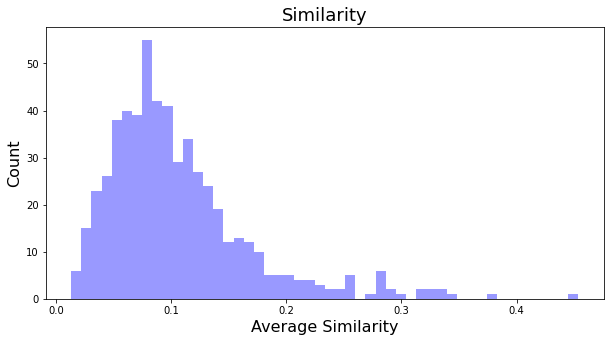

In [184]:
plt.figure(figsize=(10, 5))
sns.distplot(similarity_data['similarity'], kde=False, color='blue', bins=50)
plt.title('Similarity', fontsize=18)
plt.xlabel('Average Similarity', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([0, .4])

In [185]:
similarity_data['similarity'].describe()

count    559.000000
mean       0.105535
std        0.062249
min        0.013145
25%        0.064005
50%        0.091465
75%        0.129672
max        0.453822
Name: similarity, dtype: float64

In [186]:
similarity_data['giniXavg_min_path'] = similarity_data['gini_coefficient'] * similarity_data['avg_min_path']
similarity_data['giniXclustering'] = similarity_data['gini_coefficient'] * similarity_data['avg_clustering']
similarity_data['clusteringXavg_min_path'] = similarity_data['avg_clustering'] * similarity_data['avg_min_path']

similarity_data['giniXavg_min_pathXcrowd_pct'] = similarity_data['gini_coefficient'] * similarity_data['avg_min_path'] * similarity_data['crowd_pct']
similarity_data['giniXclusteringXcrowd_pct'] = similarity_data['gini_coefficient'] * similarity_data['avg_clustering'] * similarity_data['crowd_pct']
similarity_data['clusteringXavg_min_pathXcrowd_pct'] = similarity_data['avg_clustering'] * similarity_data['avg_min_path'] * similarity_data['crowd_pct']

similarity_data['avg_clustering_2'] = similarity_data['avg_clustering']**2
similarity_data['avg_min_path_2'] = similarity_data['avg_min_path']**2
similarity_data['gini_coefficient_2'] = similarity_data['gini_coefficient']**2

similarity_data['crowd_pct_3'] = similarity_data['crowd_pct']**3

similarity_data['log_similarity'] = np.log(similarity_data['similarity'])

In [164]:
similarity_data.columns

Index(['similarity', 'package_id_x', 'package', 'organization', 'topic_0',
       'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6',
       'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12',
       'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18',
       'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23',
       'package_id_y', 'duration_median', 'project_age', 'num_users',
       'crowd_pct', 'crowd', 'total_issues', 'gini_coefficient',
       'avg_clustering', 'avg_min_path', 'nodes', 'total_contributors',
       'avg_comments', 'avg_first_comment', 'avg_active_time', 'crowd_pct_2',
       'issues_over_time', 'avg_clusteringXcrowd_pct',
       'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
       'issues_per_user', 'giniXavg_min_path', 'giniXclustering',
       'clusteringXavg_min_path', 'giniXavg_min_pathXcrowd_pct',
       'giniXclusteringXcrowd_pct', 'clusteringXavg_min_pathXcrowd_pct',
       'avg_clustering_

In [191]:
formula = """
similarity ~ crowd_pct + crowd_pct_2 + crowd_pct_3 
    + avg_clusteringXcrowd_pct + avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct
    + avg_clustering + avg_min_path + gini_coefficient
    + project_age  + num_users + total_contributors 
    + topic_0 + topic_2 + topic_5 + topic_6 + topic_12 + topic_13 + topic_14
    + topic_15 + topic_16 + topic_17 + topic_18 + topic_19 + topic_20 + topic_21 + topic_22 + topic_23
  
"""
y, X = dmatrices(formula,
                 data=similarity_data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

29
                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     6.631
Date:                Thu, 30 Jul 2020   Prob (F-statistic):           5.44e-21
Time:                        23:01:21   Log-Likelihood:                 843.39
No. Observations:                 559   AIC:                            -1629.
Df Residuals:                     530   BIC:                            -1503.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept        